In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cov_drift'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cov_drift made!


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

pf_params_all = prepped_data_agg['pf_params_all']
all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [244]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [245]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf


In [246]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all_img = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 382 ms, sys: 5.09 s, total: 5.48 s
Wall time: 47.6 s


# signal cov, across trials

In [240]:
sess,ani=subdb.iloc[10][['sess_name','animal_name.1']]

In [335]:
ani,sess = 'e13_26m1','e13_26m1_210913'
ti,tt=0,0
fr_map_trial_df_sub=fr_map_trial_df_all.loc[ani,sess]
X=fr_map_trial_df_all.loc[ani,sess,ti,tt].dropna(axis=1,how='all')

X=X.groupby(level=0).apply(lambda x:x.rolling(5).mean()[5::5]).droplevel(0)

/tmp/ipykernel_1002681/1952493482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_sub=fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_1002681/1952493482.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  X=fr_map_trial_df_all.loc[ani,sess,ti,tt].dropna(axis=1,how='all')


In [333]:
# region='CA1'
# exp=14
# isnovel=0
# X = fr_map_trial_df_all_img.loc[region,exp,[0,1],isnovel].droplevel((0,1,3))

# X = X.unstack(level=0).sort_index(axis=1,level=1).dropna(axis=1,how='all').swaplevel(0,1,axis=1)

In [315]:
# X = X.loc[:,0]

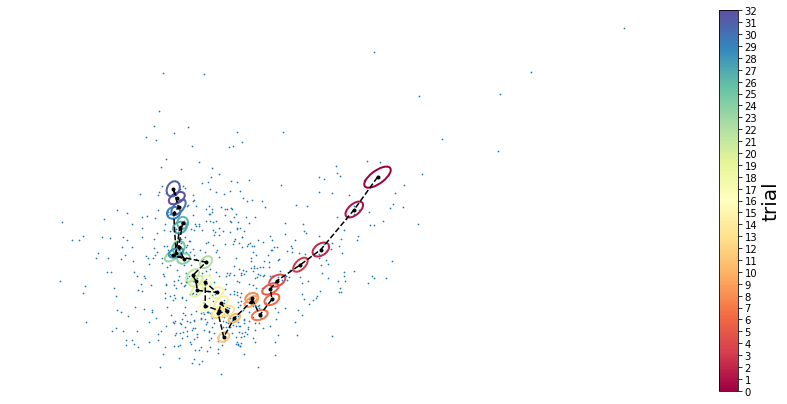

In [336]:
%matplotlib inline
mu_hat,sigma_hat,X_val,rest_ind,mu_hat_pc,sigma_hat_pc,X_pc = get_pca_mean_cov(X,do_pc=True,corr_axis=1,active_fr_thresh=0.5) 
# index = X.columns.get_level_values(1)
index = np.array([i for i in X.columns])
fig,ax = plot_pc(X_pc,mu_hat_pc,sigma_hat_pc,index,cbar_title='trial',std=0.2)



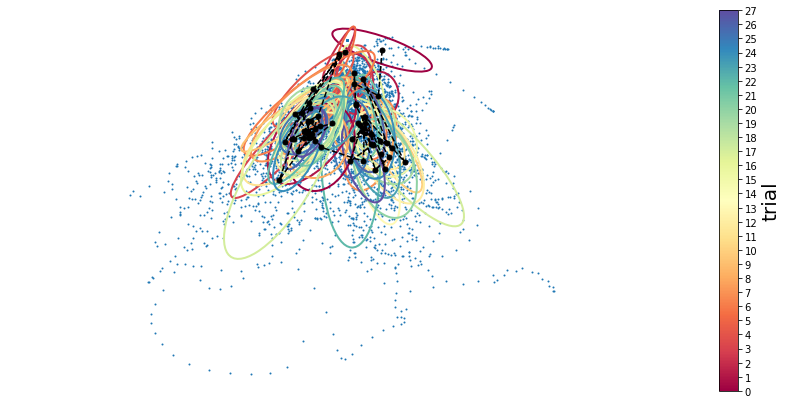

In [263]:
mu_hat,sigma_hat,X_val,rest_ind,mu_hat_pc,sigma_hat_pc,X_pc = get_pca_mean_cov(X,do_pc=True,corr_axis=1,active_fr_thresh=0.5) 
index = X.columns.get_level_values(1)
fig,ax = plot_pc(X_pc,mu_hat_pc,sigma_hat_pc,index,cbar_title='trial')

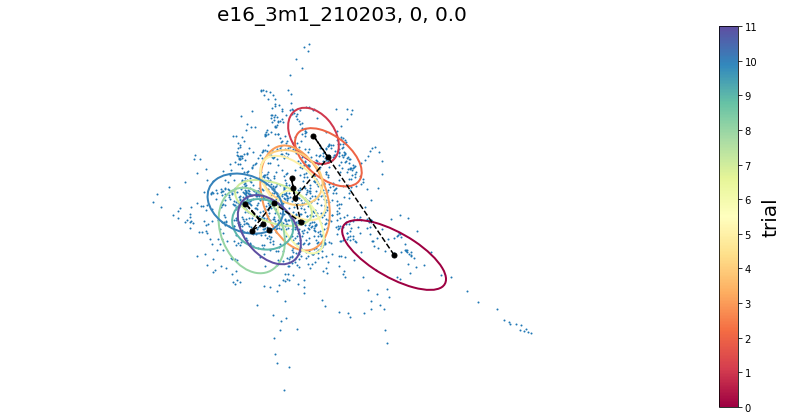

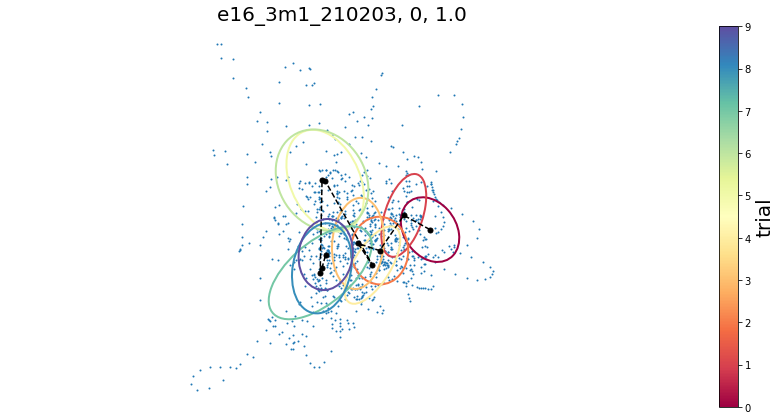

In [243]:
gpb=fr_map_trial_df_sub.groupby(level=(0,1))
for (ti,tt),val in gpb:
    X=val.loc[(ti,tt)].dropna(axis=1,how='all')
#     X=X.groupby(level=0).apply(lambda x:x.rolling(5).mean()[5::5]).droplevel(0)
    mu_hat,sigma_hat,X_val,rest_ind,mu_hat_pc,sigma_hat_pc,X_pc = get_pca_mean_cov(X,do_pc=True,corr_axis=1) 
    index = X.columns
    fig,ax = plot_pc(X_pc,mu_hat_pc,sigma_hat_pc,index,cbar_title='trial')
    ax.set_title(f'{sess}, {ti}, {tt}')

In [ ]:
mu_hat,sigma_hat,X_val,rest_ind,mu_hat_pc,sigma_hat_pc,X_pc = get_pca_mean_cov(X,do_pc=True,corr_axis=1) 
index = X.columns
fig,ax = plot_pc(X_pc,mu_hat_pc,sigma_hat_pc,index,cbar_title='trial')
ax.set_title(f'{sess}, {ti}, {tt}')

In [206]:
# nneuron=X.index.get_level_values(0).nunique()
# npos=X.index.get_level_values(1).nunique()
# ntrial=X.shape[1]


In [312]:
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
def get_pca_mean_cov(X,active_fr_thresh=1,active_trial_frac=0.3,corr_axis=1,do_zscore=True,
                     do_pc=True,n_components=2):
    '''
    corr_axis: 1: signal correlation (pos), each condition is a trial;
    2: noise correlation (trial), each condition is a position
    '''
    # preprocess
    X = X.dropna(axis=0)
    max_per_neuron_per_trial=X.groupby(level=0).max()
    ma = (max_per_neuron_per_trial > active_fr_thresh).mean(axis=1) > active_trial_frac
    rest_ind = ma.index[ma]
    X = X.loc[rest_ind]
    nneuron=X.index.get_level_values(0).nunique()
    npos=X.index.get_level_values(1).nunique()
    ntrial=X.shape[1]
    X_val =X.values.reshape(nneuron,npos,ntrial) # nneuron, npos, ntrial
    
    if do_zscore:
        X_val = (X_val - np.nanmean(X_val,axis=(1,2),keepdims=True)) / (1e-10 + np.nanstd(X_val,axis=(1,2),keepdims=True)) # per neuron
    X_val_reshape = X_val.reshape(nneuron,-1)    
    
    # get cov
    cov_l = []
    if corr_axis ==1:
        for i in range(X_val.shape[2]):
            xx=X_val[:,:,i].T # nsample (pos) x nfeature (neuron)
#             pdb.set_trace()
            xx = xx[~np.any(np.isnan(xx),1)] # select pos without nan
            cov=LedoitWolf().fit(xx).covariance_
            cov_l.append(cov)

    elif corr_axis ==2:
        for i in range(X_val.shape[1]):
            xx=X_val[:,i,:].T
            xx = xx[~np.any(np.isnan(xx),1)] # select trial without nan
            cov=LedoitWolf().fit(xx).covariance_
            cov_l.append(cov)
    sigma_hat = np.stack(cov_l,axis=0)
    
    # get mean
    mu_hat = np.nanmean(X_val,axis=corr_axis)
    
    # get pc
    if do_pc:
        pca=PCA(n_components=n_components)
        mu_hat_pc = pca.fit_transform(mu_hat.T)

        w = pca.components_
        sigma_hat_pc = np.einsum('kn,cnm,ml->ckl',w,sigma_hat,w.T)
#         pdb.set_trace()
        X_pc = pca.transform(X_val_reshape.T)
        return mu_hat,sigma_hat,X_val,rest_ind,mu_hat_pc,sigma_hat_pc,X_pc
    
    return mu_hat,sigma_hat,X_val,rest_ind
        
        
    
    
    

In [280]:
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def draw_ellipse(
        mu, cov, colors, ax, std_devs=3.0, 
        facecolor='none', linewidth=1, **kwargs
    ):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
        facecolor=facecolor, edgecolor=colors, linewidth=linewidth
    )

    scale_x = np.sqrt(cov[0, 0]) * std_devs
    scale_y = np.sqrt(cov[1, 1]) * std_devs

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0], mu[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_pc(X_pc,mu_hat_pc,sigma_hat_pc,index,fig=None,ax=None,
            std=1,linewidth=2.,s=.5,cbar_title=''
            
           ):
    if len(index.shape)==2:
        color_coord = index[:,-1] # make the color_coord the last dim
        pass
    else:
        color_coord = index
    
    cond_l = np.unique(color_coord)
    cmap = plt.cm.Spectral
    norm = mcolors.Normalize(vmin=cond_l.min(), vmax=cond_l.max())
    c_l=cmap(norm(color_coord))
    if ax is None:
        fig,ax=plt.subplots(figsize=(15,7))
    
    # scatter data points
    ax.scatter(X_pc[:,0],X_pc[:,1],s=s)
    
    # plot mean
    lst_l = ['k--','k:']
    if len(index.shape)==1:
        ax.plot(mu_hat_pc[:,0],mu_hat_pc[:,1],'k--',marker='o',ms=3)
    else:
        for tt in np.unique(index[:,0]):
            ma = index[:,0] == tt
            lst = lst_l[tt]
            ax.plot(mu_hat_pc[ma,0],mu_hat_pc[ma,1],lst,marker='o',ms=3)
        
    
    # plot cov
    if len(index.shape)==1:
        for c in range(sigma_hat_pc.shape[0]):    
            draw_ellipse(
                mu_hat_pc[c][:2],sigma_hat_pc[c][:2,:2],c_l[c],ax=plt.gca(),
                std_devs=std,linewidth=linewidth
            )
    else:
        for cc in range(sigma_hat_pc.shape[0]):
            c = index[cc,1]
            draw_ellipse(
                mu_hat_pc[cc][:2],sigma_hat_pc[cc][:2,:2],c_l[c],ax=plt.gca(),
                std_devs=std,linewidth=linewidth
            )
        
    plt.axis('equal')
    plt.axis('off')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar =fig.colorbar(sm, ticks=cond_l,ax=ax)
    cbar.set_label(cbar_title)

    
    return fig,ax
    

In [123]:
mean_pop_vec_across_pos_corr=fr_map_trial_df_all.mean(axis=1).loc[slice(None),slice(None),0].unstack().corr()

<Axes: >

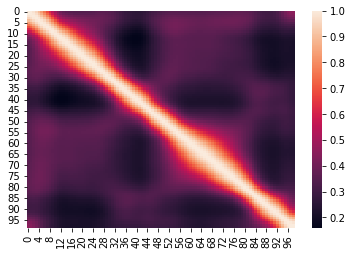

In [125]:
sns.heatmap(mean_pop_vec_across_pos_corr)

In [137]:
ma=fr_map_trial_df_all.index.get_level_values(1)!='e13_26m1_210913' 
# ma=fr_map_trial_df_all.index.get_level_values(1)=='e13_26m1_210913' 

<Axes: >

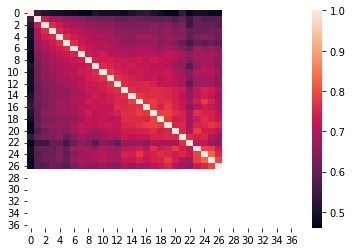

In [138]:
pop_tc_across_trial_corr = fr_map_trial_df_all.loc[ma].loc[(slice(None),slice(None),0)].corr()
sns.heatmap(pop_tc_across_trial_corr)

In [ ]:
import visualizations
reload(visualizations)
trialtype_ind = None#x[:,0]
fig,ax=visualizations.visualize_pc(mu_hat[:,None],sigma_hat,pc=y.reshape(-1,y.shape[-1]),std=.2,colors=c_l,
#                                    trialtype_ind=trialtype_ind
                                  )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar =fig.colorbar(sm, ticks=pos_l,ax=ax)
cbar.set_label('Position')
fig
# Display the plot
# plt.show()


# visualize_pc(mu_hat[:,None],sigma_hat,pc=None)